In [2]:
import numpy as np 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import pathlib
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
from pathlib import Path
import imghdr
import os
data_dir = "./Datasets/ImageRetrieval/Train/"
# add there all your images file extensions
image_extensions = [".png", ".jpg",".jpeg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            os.remove('./'+str(filepath))
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            os.remove('./'+str(filepath))
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")


In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/ImageRetrieval/Train', batch_size=128,
                                                               label_mode='categorical', image_size=(224, 224), shuffle=False)
test_ds = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/ImageRetrieval/Test', batch_size=128,
                                                               label_mode='categorical', image_size=(224, 224), seed=1)
# val_ds = tf.keras.preprocessing.image_dataset_from_directory('./Datasets/ImageRetrieval/Valid', batch_size=128,
#                                                              label_mode='categorical', image_size=(224, 224), seed=1)


Found 14811 files belonging to 10 classes.
Found 1500 files belonging to 10 classes.


In [44]:
train_ds.class_names

['Baked Potato',
 'Burger',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Pizza',
 'Sandwich',
 'Taco',
 'Taquito']

In [4]:
def format_image(image, label, paths):
    image = tf.image.resize(image, (224, 224))/255.0

    image = preprocess_input(image)
    return image, label,  tf.constant(paths)


In [5]:
train_ds = train_ds.map(lambda images, labels: format_image(images, labels, paths = train_ds.file_paths))
test_ds = test_ds.map(lambda images, labels: format_image(
    images, labels, paths=test_ds.file_paths))
# val_ds = val_ds.map(format_image)


## Third pooling layer features

In [6]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input,
              outputs=base_model.get_layer('block3_pool').output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [61]:
train_ds.class_names


['Baked Potato',
 'Burger',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Pizza',
 'Sandwich',
 'Taco',
 'Taquito']

In [7]:
from tqdm import tqdm
train_features = [[],[],[]]
path_index = 0
for items, images, paths in tqdm(train_ds):   
  current_paths = tf.constant(paths)
  predictions = model.predict(items, verbose=False)
  for prediction in predictions:
    path = tf.get_static_value(paths[path_index]).decode("utf-8")
    train_features[0].append(prediction.flatten())
    train_features[1].append(path)
    if(path_index == 0):
      print(tf.get_static_value(images[path_index]))
      print(paths[path_index])
      path_index += 1
  for label in images:
    train_features[2].append(tf.get_static_value(label))




  1%|          | 1/116 [00:09<19:01,  9.93s/it]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tf.Tensor(b'./Datasets/ImageRetrieval/Train\\Baked Potato\\Baked Potato-Train (1).jpeg', shape=(), dtype=string)


100%|██████████| 116/116 [01:07<00:00,  1.73it/s]


In [59]:
train_features[1][1]


'./Datasets/ImageRetrieval/Train\\Baked Potato\\Baked Potato-Train (10).jpeg'

In [13]:
len(train_features)

14811

In [ ]:
val_features = []
for items in tqdm(val_ds):
  predictions = model.predict(items[0])
  for prediction in predictions:
    val_features.append(prediction.flatten())


In [8]:
from tqdm import tqdm
test_features = [[], [], []]
path_index = 0
for items, images, paths in tqdm(test_ds):
  current_paths = tf.constant(paths)
  predictions = model.predict(items, verbose=False)
  for prediction in predictions:
    path = tf.get_static_value(paths[path_index]).decode("utf-8")
    test_features[0].append(prediction.flatten())
    test_features[1].append(path)
    if (path_index == 0):
      print(tf.get_static_value(images[path_index]))
      print(paths[path_index])
      path_index += 1
  for label in images:
    test_features[2].append(tf.get_static_value(label))


  0%|          | 0/12 [00:00<?, ?it/s]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
tf.Tensor(b'./Datasets/ImageRetrieval/Test\\Baked Potato\\Baked Potato-Test (91).jpeg', shape=(), dtype=string)


100%|██████████| 12/12 [00:14<00:00,  1.17s/it]


In [ ]:
full_dataset = np.concatenate((train_features, val_features))


In [9]:
import pickle

# with open('./Datasets/ImageRetrieval/ProcessedFeatures/train_feat_pool3.pkl', 'wb') as f:
#   pickle.dump(train_features, f)
# with open('./Datasets/ImageRetrieval/ProcessedFeatures/test_feat_pool3.pkl', 'wb') as f:
#   pickle.dump(test_features, f)
with open('./Datasets/ImageRetrieval/ProcessedFeatures/val_feat_pool3.pkl', 'wb') as f:
  pickle.dump(val_features, f)


In [2]:
import pickle

with open('./Datasets//ImageRetrieval/ProcessedFeatures/train_feat_pool3.pkl', 'rb') as f:
  train_features = pickle.load(f)
# with open('./ImageRetrieval/ProcessedFeatures/test_feat_pool3.pkl', 'rb') as f:
#   test_features = pickle.pickle.load(f)
# with open('./Datasets//ImageRetrieval/ProcessedFeatures/val_feat_pool3.pkl', 'rb') as f:
#   val_features = pickle.load(f)


In [6]:
full_dataset = np.concatenate((train_features, val_features))

In [8]:
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
tree = cKDTree(train_features[0], compact_nodes=False, balanced_tree=False)


In [9]:
# pip install git+https://github.com/u1234x1234/pynanoflann.git@0.0.8
import pynanoflann
nn = pynanoflann.KDTree(n_neighbors=10, metric='L2', radius=100)
nn.fit(np.array(train_features[0],dtype=np.float32))


c:\Users\Ruben\AppData\Local\Programs\Python\Python310\lib\site-packages\pynanoflann\nanoflann.py:67: UserWarning: KD Tree structure is not a good choice for high dimensional spaces.Consider a more suitable search structure.
  warnings.warn(


In [35]:
nn.save_index('index.bin')


0

In [90]:
train = np.array(train_features)

In [91]:
np.savez_compressed('./Datasets/ImageRetrieval/ProcessedFeatures/train.npz', train_features= train_features)

In [53]:
import pickle

with open('./k_tree.pkl','wb') as f:
  pickle.dump(nn, f)


In [10]:
import numpy as np
from tqdm import tqdm
from scipy.spatial import distance
from sklearn import metrics
import matplotlib.pyplot as plt

train_features = np.array(train_features)
def format_image(image):
    image = tf.image.resize(image, (224, 224))/255.0
    image = preprocess_input(image)
    image_exp = np.expand_dims(image, axis=0).copy()
    print(image_exp.shape)
    return image_exp


def search_image(img_path, model, tree, feature=None, plot=False):
  distances = None
  indices = None
  if feature is None:
    
    image = tf.keras.preprocessing.image.load_img(img_path)
    image = tf.keras.preprocessing.image.img_to_array(image)
    copy_image = image.copy()
    formatted_img = format_image(image)
    features = model.predict([formatted_img])
    print(train_features[0][0].shape)
    extr_feature = features[0]
    extr_feature = extr_feature.flatten()

  #   dists = [distance.euclidean(x, extr_feature) for x in train_features[0]]
    distances, indices = tree.kneighbors(
        np.array([extr_feature], dtype=np.float32))
  else:
    distances, indices = tree.kneighbors(
        np.array([feature], dtype=np.float32))

  # for item in tqdm(train_features[0]):
  #   distsance = distance.euclidean(item, extr_feature )
  #   dists.append(distance)
#   print(dists[0])
#   ids = np.argsort(dists)[:10]
#   print(ids)
  if plot:
    fig = plt.figure(figsize=(8, 8))
    distances = distances[0]
    indices = indices[0]

    axes = []

    for a in range(5*2):
        score = distances[a]
        axes.append(fig.add_subplot(5, 2, a+1))
        plt.axis('off')
        plt.imshow(tf.keras.preprocessing.image.load_img(
            train_features[1][indices[a]], color_mode='rgb'))
    fig.tight_layout()
    plt.show()
  return indices
  scores = [(dists[id], train_features[1][id]) for id in ids]
  print(scores)


C:\Users\Ruben\AppData\Local\Temp\ipykernel_20632\545585997.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_features = np.array(train_features)


In [ ]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input,
              outputs=base_model.get_layer('block3_pool').output)



### Evaluation

In [62]:
len(test_features[0])

1500

In [11]:
class_names = ['Baked Potato',
               'Burger',
               'Crispy Chicken',
               'Donut',
               'Fries',
               'Hot Dog',
               'Pizza',
               'Sandwich',
               'Taco',
               'Taquito']
correct = 0
total_images = 0
for i in tqdm(range(0, len(test_features[0]))):
  
  feature = test_features[0][i]
  label = test_features[2][i]
  path = test_features[1][i]
  indices = search_image('./',model, nn, feature=feature)
  indices = indices[0]
  # print(indices[0])
  # print(train_features[2][indices[0]])
  # print(label)
  for index in indices:
    if np.array_equal(train_features[2][index], label):
      correct += 1
  total_images += len(indices)
  
accuracy = correct / total_images

print(f'Were found {correct} images of correct class out of {total_images} found images, with a total accuracy of {accuracy}')



100%|██████████| 1500/1500 [06:58<00:00,  3.58it/s]

Were found 2795 images of correct class out of 15000 found images, with a total accuracy of 0.18633333333333332


In [92]:
train_features[0][0].shape

(25088,)

(1, 224, 224, 3)
1/1 [==============================] - 0s 20ms/step
(25088,)


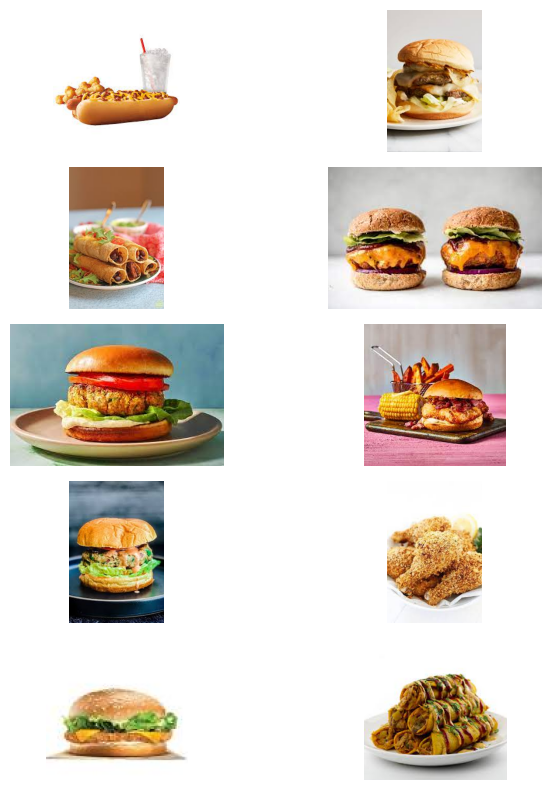

In [34]:
search_image(
    './hamburger.jpg', model)


## Last pooling layer features